# Loading the data

In [1]:
# @title Install dependencies

#!pip install pandas --quiet
#!pip install seaborn --quiet
#!pip install  pyarrow # may be needed to read data file

In [71]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# from sklearn.decomposition import PCA             # just if needed
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import Ridge

## For this example, we have pre-computed event triggered responses and saved them to figshare.
#### To access the full dataset, see `Allen_neuromatch_example_2.ipynb`, or go to the links at the bottom of this notebook
###This cell will download the responses.

In [2]:
# @title Data retrieval
import os, requests

fname = "allen_visual_behavior_2p_change_detection_familiar_novel_image_sets.parquet"
url = "https://ndownloader.figshare.com/files/28470255"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

### Then we open it using the pandas `read_parquet` method


(parquet is just another file format)

In [3]:
filename = "allen_visual_behavior_2p_change_detection_familiar_novel_image_sets.parquet"
data = pd.read_parquet(filename)

# DATA_ PROCESSING: Start here after loading data

In [4]:
#THIS IS WHERE THE FUN STARTS
# Define a function to map combinations to numbers 1-4
def map_conditions(row):
    if row['exposure_level'] == "familiar" and row['is_change'] == True:
        return 1
    elif row['exposure_level'] == "familiar" and row['is_change'] == False:
        return 2
    elif row['exposure_level'] == "novel" and row['is_change'] == True:
        return 3
    elif row['exposure_level'] == "novel" and row['is_change'] == False:
        return 4


# Apply the function to create the new column
#filtered_df['condition'] = filtered_df.apply(map_conditions, axis=1)

#print(filtered_df.shape)

In [5]:
data['condition'] = data.apply(map_conditions, axis=1)

In [6]:
outliers = []
data_traces = data.trace.values
for i in range(len(data_traces)):
    outliers.append((data_traces[i]<1).all())

data_subset_rmo = data[outliers]

In [7]:
def restrict_neurons_with_all_conditions(df):
    # Group by neuron and find unique conditions for each neuron
    neuron_conditions = df.groupby('cell_specimen_id')['condition'].unique()
    # filtering only neurons that have trials in all 4 conditions
    neurons_with_all_conditions = neuron_conditions[
        neuron_conditions.apply(lambda x: {1, 2, 3, 4}.issubset(x))
    ].index
    # Filter the data for those neurons
    filtered_d = df[df['cell_specimen_id'].isin(neurons_with_all_conditions)]
    return filtered_d
filtered_data = restrict_neurons_with_all_conditions(data_subset_rmo)

In [8]:
def verify_filtered_data(df):
    condition_counts = df.groupby('cell_specimen_id')['condition'].nunique()
    return (condition_counts == 4).all()
print(f"Verification result: {verify_filtered_data(filtered_data)}")

Verification result: True


In [9]:
#how many trials of each type per neuron? -> calculate length of each condition for each neuron - creating the trial counts variable
# Group by cell_id and 'condition', then count the number of occurrences
trial_counts = filtered_data.groupby(['cell_specimen_id', 'condition']).size().reset_index(name='trial_count')

print(trial_counts)


     cell_specimen_id  condition  trial_count
0          1086489847          1          204
1          1086489847          2          190
2          1086489847          3          218
3          1086489847          4          217
4          1086489860          1          203
..                ...        ...          ...
383        1086567017          4          184
384        1086567589          1          493
385        1086567589          2          304
386        1086567589          3          303
387        1086567589          4          152

[388 rows x 3 columns]


In [10]:
# Group by 'condition' and find the minimum 'trial_count' for each condition
min_trial_counts = trial_counts.groupby('condition')['trial_count'].min().reset_index()

# For each condition, find the neuron_id corresponding to the minimum trial_count
#min_trial_neurons = trial_counts.loc[trial_counts.groupby('condition')['trial_count'].idxmin()].reset_index(drop=True)

# Merge the two dataframes to get the condition, trial_count, and neuron_id together
#result = pd.merge(min_trial_counts, min_trial_neurons, on=['condition', 'trial_count'], suffixes=('', '_min'))

# Select only the relevant columns
min_trial_counts = min_trial_counts[['condition', 'trial_count']]

print(min_trial_counts)

   condition  trial_count
0          1          122
1          2          127
2          3           82
3          4          101


In [11]:
#ALTERNATIVE OPTION
# Sort the dataframe by 'condition' and 'trial_count' - in case we did not want the minimum but another benchmark
sorted_trial_counts = trial_counts.sort_values(by=['condition', 'trial_count'])

# Group by 'condition' and take the nth smallest 'trial_count'
second_trial_counts = sorted_trial_counts.groupby('condition').nth(0).reset_index()

print(second_trial_counts)

   condition  cell_specimen_id  trial_count
0          1        1086498976          122
1          2        1086495377          127
2          3        1086490603           82
3          4        1086498820          101


Now we need to get all neurons to have the same number of trials per condition. 

In [12]:
#CALCULATE MIN TRIALS
# Calculate the minimum number of trials for each condition
min_trials_per_condition = trial_counts.groupby('condition')['trial_count'].min()
min_trials_per_condition

condition
1    122
2    127
3     82
4    101
Name: trial_count, dtype: int64

In [13]:
#MIN_TRIALS DICTIONARY
# Convert min_trials_df to a dictionary for quick lookup
min_trials_dict = min_trials_per_condition.to_dict()
print(min_trials_dict)

{1: 122, 2: 127, 3: 82, 4: 101}


In [14]:
# Function to sample trials
def sample_trials(group, min_trials_dict, random_seed=42):
    condition = group['condition'].iloc[0]  # Extract condition from group
    min_trials = min_trials_dict.get(condition, None)  # Get minimum trials for the condition
    if min_trials is not None and len(group) > min_trials:
        return group.sample(min_trials, random_state=random_seed)
    return group


In [15]:
# Group by 'cell_id' and 'condition', then sample trials to match the minimum
balanced_df = (
    filtered_data.groupby(['cell_specimen_id', 'condition'], group_keys=False)
    .apply(lambda x: sample_trials(x, min_trials_dict))
)

#print(balanced_df)

In [16]:
#CHECKS WHETHER THINGS WORKED
#how many trials of each type per neuron? -> calculate length of each condition for each neuron
# Group by cell_id and 'condition', then count the number of occurrences
print(min_trials_dict)
trial_counts2 = balanced_df.groupby(['cell_specimen_id', 'condition']).size().reset_index(name='trial_count')

print(trial_counts2)

{1: 122, 2: 127, 3: 82, 4: 101}
     cell_specimen_id  condition  trial_count
0          1086489847          1          122
1          1086489847          2          127
2          1086489847          3           82
3          1086489847          4          101
4          1086489860          1          122
..                ...        ...          ...
383        1086567017          4          101
384        1086567589          1          122
385        1086567589          2          127
386        1086567589          3           82
387        1086567589          4          101

[388 rows x 3 columns]


array([[<Axes: title={'center': '1'}>, <Axes: title={'center': '2'}>],
       [<Axes: title={'center': '3'}>, <Axes: title={'center': '4'}>]],
      dtype=object)

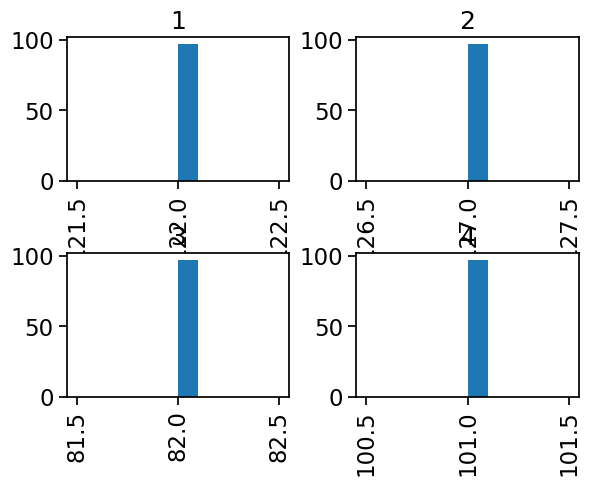

In [17]:
trial_counts2.hist(column='trial_count', by="condition")

In [18]:
# Check if all neurons have the minimum number of trials per condition
correct_counts = trial_counts2.groupby('condition')['trial_count'].nunique() == 1

print("All neurons have the same number of trials per condition:")
print(correct_counts)

All neurons have the same number of trials per condition:
condition
1    True
2    True
3    True
4    True
Name: trial_count, dtype: bool


We now need to create a feature matrix X for our decoding analysis. X should be an array containing the trace values of shape (number of neurons, number of trials, number of timepoints).

In [37]:
# we first determine our dimensions and initiate an empty numpy array of that size
N = len(balanced_df.cell_specimen_id.unique()) # the number of individual neurons left after subsetting above, here 97
S = sum(min_trial_counts.trial_count) # the *total* number of trials across conditions, here 432
T = len(balanced_df.trace.values[0]) # the number of timepoints within each trial, here 85
X = np.zeros((S,N,T))

In [38]:
# we then loop over the three dimensions and extract the values from the dataframe for each
for n, cell_id in enumerate(balanced_df.cell_specimen_id.unique()):
    neuron_data = balanced_df[balanced_df.cell_specimen_id==cell_id] # get each single neuron's data by indexing the column cell_specimen_id
    for s in range(S):
        # y[s] = neuron_data.condition.values[s]
        for t in range(T):
            X[s,n,t] = neuron_data.trace.values[s][t] # each trial is a row in the dataframe, and the column trace contains an array of trace values over time 

We also need the labels y for our model. These are now stored in the new column called condition, and since we have matched the trials across neurons, we can simply use a single neuron's label values:

In [39]:
y = neuron_data.condition.values

display(X.shape,y.shape)

(432, 97, 85)

(432,)

In [66]:
### Logistic Regression Models ###

# Create a pipeline for Logistic Regression 
Cs = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
n_folds_inner = 10
pipe_logistic = make_pipeline(
    StandardScaler(), # 'pca', PCA(n_components = 0.9) # just if needed to reduce noise or improve the prediction(s)
    LogisticRegressionCV(random_state = 0, cv = n_folds_inner, penalty='l2', Cs=Cs, max_iter=1000, n_jobs=-1) # uses stratified CV by default
   )

Steps:

* Loop over k fold stratified cross-validation:
* For each of the k loops, loop over timepoints:
* For each timepoint, split X and y into training and test set using indices for that fold
* Fit pipeline to training data
* Predict on test data
* Save all predicted y labels from each fold
* Output should be T vectors `y_predicted` of the same size of `y` (length 432, one label for each trial) containing the predicted labels for each timepoint

Note that this will take some time to run. If you do not want to use several cores, set n_jobs in cell above to 1.

In [80]:
n_folds = 10 # number of folds for k-fold CV
folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=123) # initialise folds generator
y_pred = np.zeros((T, y.shape[0])) # initialise empty array to hold the predicted labels at each timepoint
scores = np.zeros((n_folds, T)) # optional: create array to hold scores for each fold

for i, (train_ind, test_ind) in enumerate(folds.split(X[:,:,0], y)): # loop over k folds using the training and test indices from StratifiedKFold
    for t in range(T): # loop over timepoints
        X_train = X[train_ind,:,t] # split into training and test set
        y_train = y[train_ind]
        X_test = X[test_ind,:,t]
        y_test = y[test_ind]
        pipe_logistic.fit(X_train, y_train) # fit pipeline to training set
        y_pred[t, test_ind] = pipe_logistic.predict(X_test) # predict in test set
        # if you are interested in performance at each fold, save the scores from each of the folds:
        scores[i,t] = pipe_logistic.score(X_test, y_test)

We can then use the predicted labels to compute the accuracy and confusion matrix at each timepoint:

In [72]:
# initialise empty arrays to hold output
acc = np.zeros(T)
conf_mat = np.zeros((4,4,T))
for t in range(T):
    acc[t] = sum(y_pred[t,:]==y)/len(y) # accuracies are the sum of correctly predicted labels divided by the number of trials
    conf_mat[:,:,t] = confusion_matrix(y,y_pred[t]) # one confusion matrix per timepoint

Check the maximum accuracy to see the timepoint at which the decoder predicts best (to see if it picked up anything meaningful at all)

In [93]:
max(acc)

0.8541666666666666

Finally, generate some plots to investigate prediction accuracies. First calculate the chance level. There is a theoretical chance level (25% for 4 classes), here we are using the max. proportion of any class as theoretical chance. We also show the statistically significant chance levels for the given sample size of 97 neurons, as outlined in:

Combrisson & Jerbi (2015). Exceeding chance level by chance: The caveat of theoretical chance levels in brain signal classification and statistical assessment of decoding accuracy, Journal of Neuroscience Methods.

In [89]:
chance=np.max(min_trial_counts.trial_count.values/S)

In [96]:
chance05 = 0.32
chance01 = 0.35
chance001 = 0.39
chance0001 = 0.42

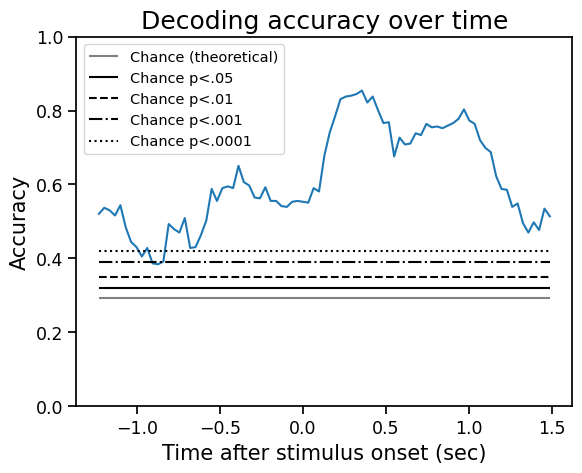

In [107]:
plt.subplot()
timestamps = data.trace_timestamps.values[0]
plt.plot(timestamps, acc)
plt.xlabel('Time after stimulus onset (sec)', fontsize='small')
plt.ylabel('Accuracy', fontsize='small')
plt.yticks(fontsize='x-small')
plt.xticks(fontsize='x-small')
plt.hlines(y=chance, xmin=min(timestamps), xmax=max(timestamps), label='Chance (theoretical)', colors='grey')
plt.hlines(y=chance05, xmin=min(timestamps), xmax=max(timestamps), label='Chance p<.05', linestyles='solid', colors='black')
plt.hlines(y=chance01, xmin=min(timestamps), xmax=max(timestamps), label='Chance p<.01', linestyles='dashed', colors='black')
plt.hlines(y=chance001, xmin=min(timestamps), xmax=max(timestamps), label='Chance p<.001', linestyles='dashdot', colors='black')
plt.hlines(y=chance0001, xmin=min(timestamps), xmax=max(timestamps), label='Chance p<.0001', linestyles='dotted', colors='black')
plt.legend(fontsize='xx-small', loc='upper left')
plt.ylim((0,1))
plt.title("Decoding accuracy over time")
plt.show()

Note that the familiar vs. novel condition is structured in blocks and therefore already present before the stimulus onset (i.e. 'half' of the information is available to the decoder at the start of the decoding interval).

We can then look at the confusion matrix. We first normalise the matrix for the true labels to take into account the proportion of trials from each condition:

In [139]:
conf_mat_norm = np.zeros((4,4,T))
for t in range(T):
    conf_mat_norm[:,:,t] = confusion_matrix(y,y_pred[t],normalize='true')

To understand which conditions are more likely to be confused (i.e. look more similar to the decoder), we first plot the confusion matrix averaged over time points:

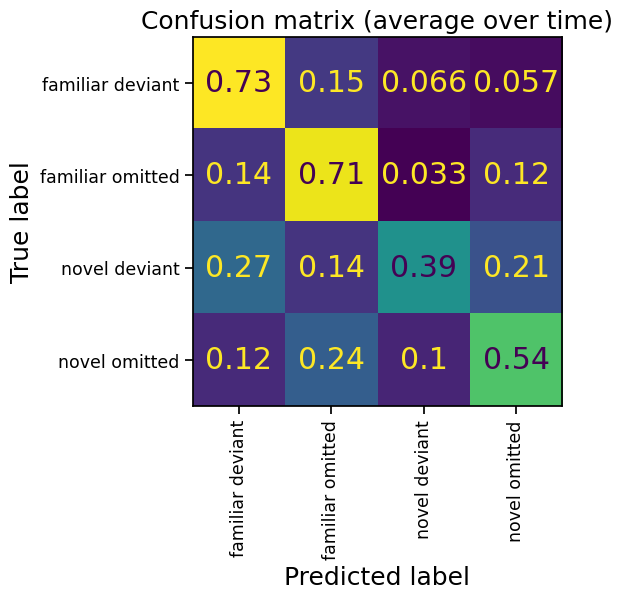

In [140]:
conf_mat_av = np.mean(conf_mat_norm,axis=2)
disp=ConfusionMatrixDisplay(conf_mat_av, display_labels=['familiar deviant', 'familiar omitted', 'novel deviant', 'novel omitted'])
disp.plot(colorbar=False, xticks_rotation='vertical', text_kw={"fontsize": 'large'})
plt.title("Confusion matrix (average over time)")
plt.yticks(fontsize='x-small')
plt.xticks(fontsize='x-small')
plt.show()

Novel stimuli are more likely to be predicted wrong at 39% and 54% accuracy for deviants and omissions, respectively, compared to 73% and 71% correct predictions for familiar stimuli. Novel deviants are likely to be confused for familiar deviants (27%), or novel omissions (21%), while novel omissions are most likely to be confused for familiar omissions (24%). Overall, this indicates that...

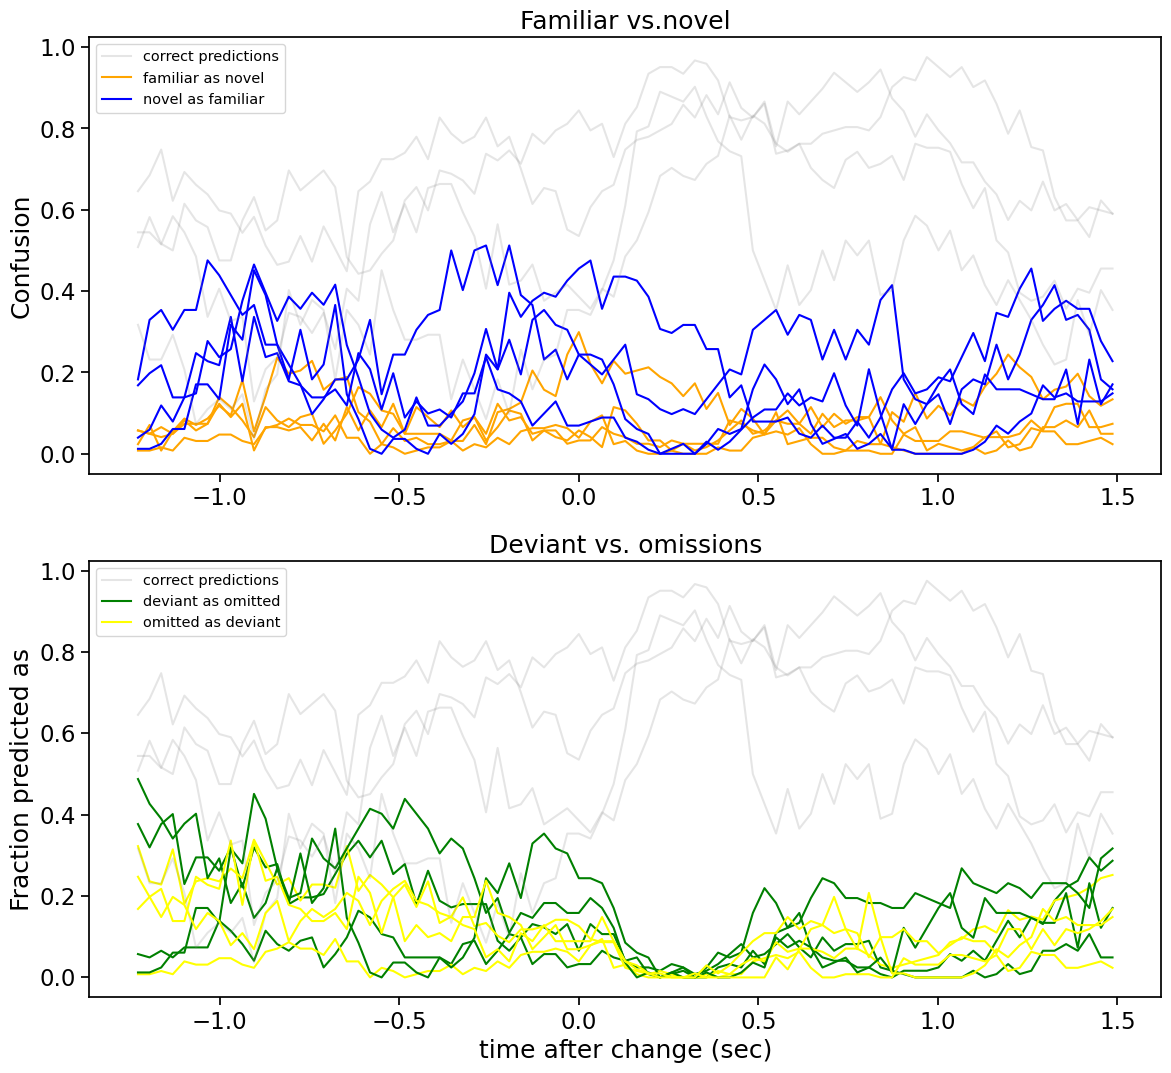

In [184]:
ts = timestamps
ax1= plt.subplot(211)
for i in range(4):
    for j in range(4):
        if i==j:
            if (i==0) & (j==0):
                plt.plot(ts, conf_mat_norm[i,j,:], color='grey', alpha=0.2, label='correct predictions')
            else:
                plt.plot(ts, conf_mat_norm[i,j,:], color='grey', alpha=0.2, label='_nolegend_')
        elif (i<2) & (j>=2):
            if (i==0) & (j==2):
                plt.plot(ts, conf_mat_norm[i,j,:], color='orange', label='familiar as novel')
            else:
                plt.plot(ts, conf_mat_norm[i,j,:], color='orange', label='_nolegend')
        elif (i>=2) & (j<2):
            if (i==2) & (j==0):
                plt.plot(ts, conf_mat_norm[i,j,:], color='blue', label='novel as familiar')
            else:
                plt.plot(ts, conf_mat_norm[i,j,:], color='blue', label='_nolegend_')

plt.legend(fontsize='xx-small')
plt.title('Familiar vs.novel')
plt.ylabel('Confusion')

plt.subplot(212, sharex=ax1, sharey=ax1)
for i in range(4):
    for j in range(4):
        if i==j:
            if (i==0) & (j==0):
                plt.plot(ts, conf_mat_norm[i,j,:], color='grey', alpha=0.2, label='correct predictions')
            else:
                plt.plot(ts, conf_mat_norm[i,j,:], color='grey', alpha=0.2, label='_nolegend_')
        elif ((i==1)|(i==3)) & ((j==0)|(j==2)):
            if (i==1) & (j==0):
                plt.plot(ts, conf_mat_norm[i,j,:], color='yellow', label='omitted as deviant')
            else:
                plt.plot(ts, conf_mat_norm[i,j,:], color='yellow', label='_nolegend')
        elif ((i==0)|(i==2)) & ((j==1)|(j==3)):
            if (i==0) & (j==1):
                plt.plot(ts, conf_mat_norm[i,j,:], color='green', label='deviant as omitted')
            else:
                plt.plot(ts, conf_mat_norm[i,j,:], color='green', label='_nolegend_')
plt.legend(fontsize='xx-small')
plt.title('Deviant vs. omissions')
plt.xlabel('time after change (sec)')
plt.ylabel('Fraction predicted as')

plt.subplots_adjust(bottom=-0.5, right=1.8, top=1.5)
plt.show()